In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools
import scipy.stats
import iminuit

Welcome to JupyROOT 6.18/04


In [2]:
plt.style.use("cms")

In [3]:
with pd.HDFStore("hists_wjets_pred.h5") as store:
    print(store.keys())

['/MCAggEvents', '/MCAggEvents_jec', '/MCAggEvents_lepscales']


In [4]:
#df_data = pd.read_hdf("hists_wjets_pred.h5", "DataAggEvents")
df_mc = pd.read_hdf("hists_wjets_pred.h5", "MCAggEvents")
df_mc_jec = pd.read_hdf("hists_wjets_pred.h5", "MCAggEvents_jec")
df_mc_lep = pd.read_hdf("hists_wjets_pred.h5", "MCAggEvents_lepscales")
df_mc.head(10)

count      sum_w  \
table   varname0  selection      parent          binvar0                     
central METnoX_pt DoubleElectron WJetsToEMinusNu 225.0      1.0  -0.000127   
                                                 230.0      1.0   0.166145   
                                                 235.0      1.0   0.185788   
                                                 245.0      1.0   0.162955   
                                                 255.0      1.0   0.146956   
                                                 265.0      1.0   0.170916   
                                                 290.0      1.0  13.180287   
                                                 300.0      1.0   0.524513   
                                                 305.0      1.0   0.173534   
                                                 340.0      1.0   0.144252   

                                                                sum_ww  \
table   varname0  selection      parent          binvar0                 
central METnoX_pt DoubleElectron WJetsToEMinusNu 225.0    1.613908e-08   
                                                 230.0    2.760418e-02   
                                                 235.0    3.451716e-02   
                                                 245.0    2.655449e-02   
                                                 255.0    2.159619e-02   
                                                 265.0    2.921213e-02   
                                                 290.0    1.737200e+02   
                                                 300.0    2.751139e-01   
                                                 305.0    3.011415e-02   
                                                 340.0    2.080851e-02   

                                                          sum_w_d1kqcdUp  \
table   varname0  selection      parent          binvar0                   
central METnoX_pt DoubleElectron WJetsToEMinusNu 225.0         -0.000120   
                                                 230.0          0.157576   
                                                 235.0          0.176206   
                                                 245.0          0.154551   
                                                 255.0          0.139377   
                                                 265.0          0.162572   
                                                 290.0         12.586511   
                                                 300.0          0.498907   
                                                 305.0          0.165063   
                                                 340.0          0.136642   

                                                          sum_ww_d1kqcdUp  \
table   varname0  selection      parent          binvar0                    
central METnoX_pt DoubleElectron WJetsToEMinusNu 225.0       1.451732e-08   
                                                 230.0       2.483033e-02   
                                                 235.0       3.104865e-02   
                                                 245.0       2.388612e-02   
                                                 255.0       1.942606e-02   
                                                 265.0       2.642960e-02   
                                                 290.0       1.584203e+02   
                                                 300.0       2.489085e-01   
                                                 305.0       2.724570e-02   
                                                 340.0       1.867104e-02   

                                                          sum_w_d1kqcdDown  \
table   varname0  selection      parent          binvar0                     
central METnoX_pt DoubleElectron WJetsToEMinusNu 225.0           -0.000135   
                                                 230.0            0.176121   
                                                 235.0            0.196943   
    

# Final binning

Use the final MET bins

In [5]:
met_bins = np.array([200., 220., 250., 280., 310., 340., 370., 400., 430., 470., 510., 550., 590., 640., 690., 740., 790., 840., 900., 960., 1020., 1090., 1160., 1250., 1400.])

In [6]:
#_df_data = dftools.transform.rebin(df_data, met_bins)

processes = {
    #"ZJetsToNuNu": ["ZJetsToNuNu"],
    "DYJetsToLL": ["DYJetsToEE", "DYJetsToMuMu", "DYJetsToTauHTauH", "DYJetsToTauHTauL", "DYJetsToTauLTauL"],
    "WJetsToLNu": [
        "WJetsToEMinusNu", "WJetsToEPlusNu", "WJetsToMuMinusNu", "WJetsToMuPlusNu",
        "WJetsToTauLMinusNu", "WJetsToTauLPlusNu", "WJetsToTauHMinusNu", "WJetsToTauHPlusNu",
    ],
    "MinorBkgs": ["Diboson", "EWKV2Jets", "G1Jet", "SingleTop", "TTJets", "VGamma"],
    #"QCD": ["QCD"],
}

_df_mc = dftools.transform.merge(dftools.transform.rebin(df_mc, met_bins), processes)
_df_mc_jec = dftools.transform.merge(dftools.transform.rebin(df_mc_jec, met_bins), processes)
_df_mc_lep = dftools.transform.merge(dftools.transform.rebin(df_mc_lep, met_bins), processes)
pass

# Fits

## Setup

### Data

In [7]:
path_fit_inputs = "fitinputs.h5"
save = True

In [8]:
# # Rebin
# df_data_fit = _df_data.loc[("central", "METnoX_pt"),:]
# 
# # Rename
# df_data_fit = df_data_fit.reorder_levels(["binvar0", "selection", "parent"]).unstack().unstack()
# df_data_fit["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
# df_data_fit = df_data_fit.set_index(["binvar1"], append=True).stack().stack().reorder_levels(["parent", "selection", "binvar0", "binvar1"]).sort_index()
# df_data_fit.index.names = ["trigger", "region", "bin_min", "bin_max"]
# 
# # Save
# if save:
#     with pd.HDFStore(path_fit_inputs) as store:
#         if "Data" in store.keys():
#             store.remove("Data")
#         store.put("Data", df_data_fit, format='table', append=True, complib='zlib', complevel=9)
# df_data_fit.head(5)

# MC PDFs

In [9]:
nom = _df_mc["sum_w"]
var = _df_mc["sum_ww"]
std = _df_mc[(c for c in _df_mc.columns if "sum_w_lhePdf" in c)].std(axis=1)

df_mc_pdf = pd.DataFrame({
    "sum_w_lhePdfWeightUp": nom + std,
    "sum_ww_lhePdfWeightUp": var * (1 + std/nom)**2,
    "sum_w_lhePdfWeightDown": nom - std,
    "sum_ww_lhePdfWeightDown": var * (1 - std/nom)**2,
}, index=nom.index).fillna(0.)

df_mc_pdf.head(5)

sum_w_lhePdfWeightUp  \
table   varname0  selection      parent     binvar0                         
central METnoX_pt DoubleElectron WJetsToLNu 200.0                0.000000   
                                            220.0                0.522902   
                                            250.0                0.322640   
                                            280.0               14.185627   
                                            310.0                0.000000   

                                                     sum_ww_lhePdfWeightUp  \
table   varname0  selection      parent     binvar0                          
central METnoX_pt DoubleElectron WJetsToLNu 200.0                 0.000000   
                                            220.0                 0.091503   
                                            250.0                 0.052344   
                                            280.0               181.817010   
                                            310.0                 0.000000   

                                                     sum_w_lhePdfWeightDown  \
table   varname0  selection      parent     binvar0                           
central METnoX_pt DoubleElectron WJetsToLNu 200.0                  0.000000   
                                            220.0                  0.506621   
                                            250.0                  0.313104   
                                            280.0                 13.571042   
                                            310.0                  0.000000   

                                                     sum_ww_lhePdfWeightDown  
table   varname0  selection      parent     binvar0                           
central METnoX_pt DoubleElectron WJetsToLNu 200.0                   0.000000  
                                            220.0                   0.085894  
                                            250.0                   0.049296  
                                            280.0                 166.404020  
                                            310.0                   0.000000

# MC QCD Scales

In [10]:
nom = _df_mc["sum_w"]
var = _df_mc["sum_ww"]
mini = _df_mc[(c for c in _df_mc.columns if "sum_w_lheScale" in c)].min(axis=1)
maxi = _df_mc[(c for c in _df_mc.columns if "sum_w_lheScale" in c)].max(axis=1)

df_mc_scale = pd.DataFrame({
    "sum_w_lheScaleWeightUp": maxi,
    "sum_ww_lheScaleWeightUp": var * (maxi/nom)**2,
    "sum_w_lheScaleWeightDown": mini,
    "sum_ww_lheScaleWeightDown": var * (mini/nom)**2,
}, index=nom.index).fillna(0.)

df_mc_scale.head(5)

sum_w_lheScaleWeightUp  \
table   varname0  selection      parent     binvar0                           
central METnoX_pt DoubleElectron WJetsToLNu 200.0                  0.000000   
                                            220.0                  0.514761   
                                            250.0                  0.317872   
                                            280.0                 13.878334   
                                            310.0                  0.000000   

                                                     sum_ww_lheScaleWeightUp  \
table   varname0  selection      parent     binvar0                            
central METnoX_pt DoubleElectron WJetsToLNu 200.0                   0.000000   
                                            220.0                   0.088676   
                                            250.0                   0.050808   
                                            280.0                 174.025197   
                                            310.0                   0.000000   

                                                     sum_w_lheScaleWeightDown  \
table   varname0  selection      parent     binvar0                             
central METnoX_pt DoubleElectron WJetsToLNu 200.0                    0.000000   
                                            220.0                    0.514761   
                                            250.0                    0.317872   
                                            280.0                   13.878334   
                                            310.0                    0.000000   

                                                     sum_ww_lheScaleWeightDown  
table   varname0  selection      parent     binvar0                             
central METnoX_pt DoubleElectron WJetsToLNu 200.0                     0.000000  
                                            220.0                     0.088676  
                                            250.0                     0.050808  
                                            280.0                   174.025197  
                                            310.0                     0.000000

# MC alphas

In [11]:
df_mc_alphas = pd.DataFrame({
    "sum_w_alphasUp": _df_mc.eval("sum_w_alphasUp"),
    "sum_ww_alphasUp": _df_mc.eval("sum_ww_alphasUp"),
    "sum_w_alphasDown": _df_mc.eval("sum_w**2/sum_w_alphasUp"),
    "sum_ww_alphasDown": _df_mc.eval("sum_ww*(sum_w/sum_w_alphasUp)**2"),
}, index=_df_mc["sum_w"].index).fillna(0.)

df_mc_alphas.head(5)

sum_w_alphasUp  \
table   varname0  selection      parent     binvar0                   
central METnoX_pt DoubleElectron WJetsToLNu 200.0          0.000000   
                                            220.0          0.523186   
                                            250.0          0.324022   
                                            280.0         14.114995   
                                            310.0          0.000000   

                                                     sum_ww_alphasUp  \
table   varname0  selection      parent     binvar0                    
central METnoX_pt DoubleElectron WJetsToLNu 200.0           0.000000   
                                            220.0           0.091731   
                                            250.0           0.052799   
                                            280.0         180.003738   
                                            310.0           0.000000   

                                                     sum_w_alphasDown  \
table   varname0  selection      parent     binvar0                     
central METnoX_pt DoubleElectron WJetsToLNu 200.0            0.000000   
                                            220.0            0.506472   
                                            250.0            0.311839   
                                            280.0           13.645642   
                                            310.0            0.000000   

                                                     sum_ww_alphasDown  
table   varname0  selection      parent     binvar0                     
central METnoX_pt DoubleElectron WJetsToLNu 200.0             0.000000  
                                            220.0             0.085843  
                                            250.0             0.048898  
                                            280.0           168.238497  
                                            310.0             0.000000

# MC JES and LEP Scales

In [12]:
df_var = pd.concat([_df_mc_jec, _df_mc_lep], axis=0)
df_mc_jec_lep = pd.pivot_table(df_var, values=["sum_w", "sum_ww"], index=["varname0", "selection", "parent", "binvar0"], columns=["table"], fill_value=0.)
df_mc_jec_lep.columns = ["_".join(c) for c in df_mc_jec_lep.columns]
df_mc_jec_lep["table"] = "central"
df_mc_jec_lep = (
    df_mc_jec_lep.set_index("table", append=True)
    .reorder_levels(["table", "varname0", "selection", "parent", "binvar0"])
)
df_mc_jec_lep

sum_w_eleEnergyScaleDown  \
table   varname0  selection      parent     binvar0                             
central METnoX_pt DoubleElectron WJetsToLNu 200.0                    0.000000   
                                            220.0                    0.515018   
                                            250.0                    0.317858   
                                            280.0                   13.878326   
                                            310.0                    0.000000   
...                                                                       ...   
                  SingleTau      WJetsToLNu 1020.0                  13.667650   
                                            1090.0                   1.886906   
                                            1160.0                  21.617464   
                                            1250.0                   0.816064   
                                            1400.0                  10.788216   

                                                     sum_w_eleEnergyScaleUp  \
table   varname0  selection      parent     binvar0                           
central METnoX_pt DoubleElectron WJetsToLNu 200.0                  0.000000   
                                            220.0                  0.514762   
                                            250.0                  0.321178   
                                            280.0                 13.716775   
                                            310.0                  0.000000   
...                                                                     ...   
                  SingleTau      WJetsToLNu 1020.0                13.716645   
                                            1090.0                 1.983333   
                                            1160.0                21.665948   
                                            1250.0                 0.923961   
                                            1400.0                10.805827   

                                                     sum_w_jerSFDown  \
table   varname0  selection      parent     binvar0                    
central METnoX_pt DoubleElectron WJetsToLNu 200.0           0.000000   
                                            220.0           0.351806   
                                            250.0           0.480827   
                                            280.0          13.814636   
                                            310.0           0.173534   
...                                                              ...   
                  SingleTau      WJetsToLNu 1020.0         13.660719   
                                            1090.0          1.949370   
                                            1160.0         21.557586   
                                            1250.0          0.815197   
                                            1400.0         10.786367   

                                                     sum_w_jerSFUp  \
table   varname0  selection      parent     binvar0                  
central METnoX_pt DoubleElectron WJetsToLNu 200.0         0.000000   
                                            220.0         0.351806   
                                            250.0         0.317872   
                                            280.0        13.878334   
                                            310.0         0.144252   
...                                                            ...   
                  SingleTau      WJetsToLNu 1020.0       13.780726   
                                            1090.0        1.855457   
                                            1160.0       21.448775   
                                            1250.0        0.819921   
                                            1400.0       10.917353   

                                                     sum_w_jesTotalDown  \
table   varname0  selection      parent     binv

# MC Lumi variations

In [13]:
df_mc_lumi= pd.concat([
    _df_mc[["sum_w", "sum_ww"]]*1.025,
    _df_mc[["sum_w", "sum_ww"]]/1.025,
], axis=1)
df_mc_lumi.columns = ["sum_w_lumiUp", "sum_ww_lumiUp", "sum_w_lumiDown", "sum_ww_lumiDown"]
df_mc_lumi.head(5)

sum_w_lumiUp  \
table   varname0  selection      parent     binvar0                 
central METnoX_pt DoubleElectron WJetsToLNu 200.0        0.000000   
                                            220.0        0.527631   
                                            250.0        0.325819   
                                            280.0       14.225293   
                                            310.0        0.000000   

                                                     sum_ww_lumiUp  \
table   varname0  selection      parent     binvar0                  
central METnoX_pt DoubleElectron WJetsToLNu 200.0         0.000000   
                                            220.0         0.090893   
                                            250.0         0.052079   
                                            280.0       178.375827   
                                            310.0         0.000000   

                                                     sum_w_lumiDown  \
table   varname0  selection      parent     binvar0                   
central METnoX_pt DoubleElectron WJetsToLNu 200.0          0.000000   
                                            220.0          0.502206   
                                            250.0          0.310119   
                                            280.0         13.539838   
                                            310.0          0.000000   

                                                     sum_ww_lumiDown  
table   varname0  selection      parent     binvar0                   
central METnoX_pt DoubleElectron WJetsToLNu 200.0           0.000000  
                                            220.0           0.086513  
                                            250.0           0.049569  
                                            280.0         169.780680  
                                            310.0           0.000000

# MC collect everything

In [15]:
if "sum_w_alphasUp" in _df_mc.columns:
    _df_mc = _df_mc.drop(["sum_w_alphasUp", "sum_ww_alphasUp"], axis=1)
if "sum_w_alphasDown" in _df_mc.columns:
    _df_mc = _df_mc.drop(["sum_w_alphasDown", "sum_ww_alphasDown"], axis=1)
_df_mc = _df_mc.drop((c for c in _df_mc.columns if ("sum_w_lhePdf" in c) or ("sum_ww_lhePdf" in c)), axis=1)
_df_mc = _df_mc.drop((c for c in _df_mc.columns if ("sum_w_lheScale" in c) or ("sum_ww_lheScale" in c)), axis=1)

# Add other variations
kwargs = dict(how='outer', left_index=True, right_index=True)
df_mc_fit = (
    _df_mc.loc[("central", "METnoX_pt"), :]
    .merge(df_mc_lumi, **kwargs)
    .merge(df_mc_pdf, **kwargs)
    .merge(df_mc_scale, **kwargs)
    .merge(df_mc_alphas, **kwargs)
    .merge(df_mc_jec_lep, **kwargs)
    .fillna(0.)
    .drop("count", axis=1)
    .reset_index(["table", "varname0"], drop=True)
)
df_mc_fit.columns.name = "variation"
df_mc_fit = df_mc_fit.stack().reset_index("variation")
df_mc_fit["quantity"] = "sum_w"
df_mc_fit.loc[df_mc_fit["variation"].str.startswith("sum_ww"), "quantity"] = "sum_ww"
df_mc_fit.loc[:,"variation"] = (
    df_mc_fit["variation"].str.replace("sum_ww_", "")
    .str.replace("sum_w_", "")
    .str.replace("sum_ww", "")
    .str.replace("sum_w", "")
)
df_mc_fit = (
    df_mc_fit.set_index(["variation", "quantity"], append=True)
    .unstack()
    .reorder_levels(["selection", "parent", "variation", "binvar0"])
    .sort_index()
)
df_mc_fit.columns = ["sum_w", "sum_ww"]

# Rename
df_mc_fit = df_mc_fit.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit = df_mc_fit.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if "MC" in store.keys():
            store.remove("MC")
        store.put("MC", df_mc_fit, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit.head(5)

sum_w      sum_ww
region         process    variation bin_min bin_max                       
DoubleElectron WJetsToLNu           200.0   220.0     0.000000    0.000000
                                    220.0   250.0     0.514761    0.088676
                                    250.0   280.0     0.317872    0.050808
                                    280.0   310.0    13.878334  174.025197
                                    310.0   340.0     0.000000    0.000000

# MC Smooth

In [16]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].reset_index(["variation", "bin_min", "bin_max"])
df_mc_fit_vari["updown"] = "Up"
df_mc_fit_vari.loc[df_mc_fit_vari["variation"].str.endswith("Down"), "updown"] = "Down"
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["variation"].str.endswith("Down"),
    df_mc_fit_vari["variation"].str.slice(0, -4),
    df_mc_fit_vari["variation"].str.slice(0, -2),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "bin_min", "bin_max", "updown"], append=True).unstack()
df_mc_fit_vari.columns = ["_".join(c) for c in df_mc_fit_vari.columns]

# add nominal values
df_mc_fit_vari = pd.merge(
    df_mc_fit_vari,
    df_mc_fit.loc[nominal_mask,:].reset_index("variation", drop=True),
    right_index=True, left_index=True,
)
df_mc_fit_vari["bin_cent"] = (df_mc_fit_vari.index.get_level_values("bin_min")+df_mc_fit_vari.index.get_level_values("bin_max"))/2.
df_mc_fit_vari["up_norm"] = df_mc_fit_vari.eval("sum_w_Up/sum_w")
df_mc_fit_vari["do_norm"] = df_mc_fit_vari.eval("sum_w_Down/sum_w")
df_mc_fit_vari["up_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Up - sum_ww_Down))/sum_w")
df_mc_fit_vari["do_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Down - sum_ww))/sum_w")

mask = (df_mc_fit_vari["sum_w"]==0.)
df_mc_fit_vari.loc[mask, "up_norm"] = 1.
df_mc_fit_vari.loc[mask, "do_norm"] = 1.
df_mc_fit_vari.loc[mask, "up_err"] = 100.
df_mc_fit_vari.loc[mask, "do_err"] = 100.

mask = (df_mc_fit_vari["do_err"]==0.)
df_mc_fit_vari.loc[mask, "do_err"] = df_mc_fit_vari.loc[mask, "up_err"].copy()

df_mc_fit_vari.loc[:, "up_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["up_err"]))
df_mc_fit_vari.loc[:, "do_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["do_err"]))

#def unispline_to_gausfilter(x, y):
#    s = UnivariateSpline(x, y, w=err)
def smoother(df):
    return pd.DataFrame({
        "upsmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["up_norm"].values, w=1./df["up_err"],
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #, "s": df.shape[0]*4},
        ),
        "dosmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["do_norm"].values, w=1./df["do_err"],
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #"s": df.shape[0]*4},
        ),
    }, index=df.index)

df_mc_fit_vari = pd.concat([
    df_mc_fit_vari,
    df_mc_fit_vari.groupby(["region", "process", "variation"]).apply(smoother)
], axis=1)
df_mc_fit_vari["sum_w_upsmooth"] = df_mc_fit_vari.eval("sum_w*upsmooth")
df_mc_fit_vari["sum_w_dosmooth"] = df_mc_fit_vari.eval("sum_w*dosmooth")
df_mc_fit_vari_sum = df_mc_fit_vari[["sum_w", "sum_w_Up", "sum_w_Down", "sum_w_upsmooth", "sum_w_dosmooth"]].groupby(["region", "process", "variation"]).sum()

df_mc_fit_vari = df_mc_fit_vari.reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

sum_w_up = df_mc_fit_vari.eval("sum_w*upsmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Up/sum_w_upsmooth"))
sum_w_do = df_mc_fit_vari.eval("sum_w*dosmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Down/sum_w_dosmooth"))

df_mc_fit_vari = pd.DataFrame({
    "sum_wUp": sum_w_up.values,
    "sum_wwUp": df_mc_fit_vari["sum_ww_Up"].values,
    "sum_wDown": sum_w_do.values,
    "sum_wwDown": df_mc_fit_vari["sum_ww_Down"].values,
}, index=df_mc_fit_vari.index)

df_mc_fit_vari.columns.name = "type"
df_mc_fit_vari = df_mc_fit_vari.stack().reset_index(["variation", "type"])
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["variation"]+"Up",
    df_mc_fit_vari["variation"]+"Down",
)
df_mc_fit_vari.loc[:, "type"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["type"].str.slice(0, -2),
    df_mc_fit_vari["type"].str.slice(0, -4),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "type"], append=True).unstack().reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max"
]).sort_index()
df_mc_fit_vari.columns = [c[1] for c in df_mc_fit_vari.columns]

print(df_mc_fit_vari)

# Add nominal
df_mc_nom = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww")].copy()
df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()
df_mc_fit_smooth = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Rename
df_mc_fit_smooth = df_mc_fit_smooth.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit_smooth["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit_smooth = df_mc_fit_smooth.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit_smooth.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
name = "MCSmooth"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_smooth, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_smooth

                                                          sum_w      sum_ww
region         process    variation  bin_min bin_max                       
DoubleElectron WJetsToLNu alphasDown 200.0   220.0    -0.000000    0.000000
                                     220.0   250.0    -0.164390    0.085843
                                     250.0   280.0     0.075819    0.048898
                                     280.0   310.0    14.382067  168.238497
                                     310.0   340.0     0.000000    0.000000
...                                                         ...         ...
SingleTau      WJetsToLNu unclustUp  1020.0  1090.0   13.730780  105.875573
                                     1090.0  1160.0    1.974742    0.074699
                                     1160.0  1250.0   21.535545  198.458174
                                     1250.0  1400.0    0.853739    0.037625
                                     1400.0  1550.0   10.732019   95.066695

[34400 rows

sum_w      sum_ww
region         process    variation bin_min bin_max                       
DoubleElectron WJetsToLNu           200.0   220.0     0.000000    0.000000
                                    220.0   250.0     0.514761    0.088676
                                    250.0   280.0     0.317872    0.050808
                                    280.0   310.0    13.878334  174.025197
                                    310.0   340.0     0.000000    0.000000
...                                                        ...         ...
SingleTau      WJetsToLNu unclustUp 1020.0  1090.0   13.730780  105.875573
                                    1090.0  1160.0    1.974742    0.074699
                                    1160.0  1250.0   21.535545  198.458174
                                    1250.0  1400.0    0.853739    0.037625
                                    1400.0  1550.0   10.732019   95.066695

[34800 rows x 2 columns]

In [17]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].reset_index(["variation", "bin_min", "bin_max"])
df_mc_fit_vari["updown"] = "Up"
df_mc_fit_vari.loc[df_mc_fit_vari["variation"].str.endswith("Down"), "updown"] = "Down"
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["variation"].str.endswith("Down"),
    df_mc_fit_vari["variation"].str.slice(0, -4),
    df_mc_fit_vari["variation"].str.slice(0, -2),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "bin_min", "bin_max", "updown"], append=True).unstack()
df_mc_fit_vari.columns = ["_".join(c) for c in df_mc_fit_vari.columns]

# add nominal values
df_mc_fit_vari = pd.merge(
    df_mc_fit_vari,
    df_mc_fit.loc[nominal_mask,:].reset_index("variation", drop=True),
    right_index=True, left_index=True,
)
df_mc_fit_vari["bin_cent"] = (df_mc_fit_vari.index.get_level_values("bin_min")+df_mc_fit_vari.index.get_level_values("bin_max"))/2.
df_mc_fit_vari["up_norm"] = df_mc_fit_vari.eval("sum_w_Up/sum_w")
df_mc_fit_vari["do_norm"] = df_mc_fit_vari.eval("sum_w_Down/sum_w")
df_mc_fit_vari["up_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Up - sum_ww_Down))/sum_w")
df_mc_fit_vari["do_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Down - sum_ww))/sum_w")

mask = (df_mc_fit_vari["sum_w"]==0.)
df_mc_fit_vari.loc[mask, "up_norm"] = 1.
df_mc_fit_vari.loc[mask, "do_norm"] = 1.
df_mc_fit_vari.loc[mask, "up_err"] = 100.
df_mc_fit_vari.loc[mask, "do_err"] = 100.

mask = (df_mc_fit_vari["do_err"]==0.)
df_mc_fit_vari.loc[mask, "do_err"] = df_mc_fit_vari.loc[mask, "up_err"].copy()

df_mc_fit_vari.loc[:, "up_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["up_err"]))
df_mc_fit_vari.loc[:, "do_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["do_err"]))

#def unispline_to_gausfilter(x, y):
#    s = UnivariateSpline(x, y, w=err)
def smoother(df):
    return pd.DataFrame({
        "upsmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["up_norm"].values, w=1./df["up_err"]**2,
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #, "s": df.shape[0]*4},
        ),
        "dosmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["do_norm"].values, w=1./df["do_err"]**2,
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #"s": df.shape[0]*4},
        ),
    }, index=df.index)

df_mc_fit_vari = pd.concat([
    df_mc_fit_vari,
    df_mc_fit_vari.groupby(["region", "process", "variation"]).apply(smoother)
], axis=1)
df_mc_fit_vari["sum_w_upsmooth"] = df_mc_fit_vari.eval("sum_w*upsmooth")
df_mc_fit_vari["sum_w_dosmooth"] = df_mc_fit_vari.eval("sum_w*dosmooth")
df_mc_fit_vari_sum = df_mc_fit_vari[["sum_w", "sum_w_Up", "sum_w_Down", "sum_w_upsmooth", "sum_w_dosmooth"]].groupby(["region", "process", "variation"]).sum()

df_mc_fit_vari = df_mc_fit_vari.reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

sum_w_up = df_mc_fit_vari.eval("sum_w*upsmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Up/sum_w_upsmooth"))
sum_w_do = df_mc_fit_vari.eval("sum_w*dosmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Down/sum_w_dosmooth"))

df_mc_fit_vari = pd.DataFrame({
    "sum_wUp": sum_w_up.values,
    "sum_wwUp": df_mc_fit_vari["sum_ww_Up"].values,
    "sum_wDown": sum_w_do.values,
    "sum_wwDown": df_mc_fit_vari["sum_ww_Down"].values,
}, index=df_mc_fit_vari.index)

df_mc_fit_vari.columns.name = "type"
df_mc_fit_vari = df_mc_fit_vari.stack().reset_index(["variation", "type"])
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["variation"]+"Up",
    df_mc_fit_vari["variation"]+"Down",
)
df_mc_fit_vari.loc[:, "type"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["type"].str.slice(0, -2),
    df_mc_fit_vari["type"].str.slice(0, -4),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "type"], append=True).unstack().reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max"
]).sort_index()
df_mc_fit_vari.columns = [c[1] for c in df_mc_fit_vari.columns]

print(df_mc_fit_vari)

# Add nominal
df_mc_nom = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww")].copy()
df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()
df_mc_fit_smooth = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Rename
df_mc_fit_smooth = df_mc_fit_smooth.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit_smooth["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit_smooth = df_mc_fit_smooth.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit_smooth.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
name = "MCSmoothv2"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_smooth, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_smooth

/vols/build/cms/sdb15/miniconda2/envs/zinv38/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


                                                          sum_w      sum_ww
region         process    variation  bin_min bin_max                       
DoubleElectron WJetsToLNu alphasDown 200.0   220.0    -0.000000    0.000000
                                     220.0   250.0    -0.059015    0.085843
                                     250.0   280.0     0.117552    0.048898
                                     280.0   310.0    14.284711  168.238497
                                     310.0   340.0     0.000000    0.000000
...                                                         ...         ...
SingleTau      WJetsToLNu unclustUp  1020.0  1090.0   13.690557  105.875573
                                     1090.0  1160.0    1.964200    0.074699
                                     1160.0  1250.0   21.376205  198.458174
                                     1250.0  1400.0    0.846500    0.037625
                                     1400.0  1550.0   10.637670   95.066695

[34400 rows

sum_w      sum_ww
region         process    variation bin_min bin_max                       
DoubleElectron WJetsToLNu           200.0   220.0     0.000000    0.000000
                                    220.0   250.0     0.514761    0.088676
                                    250.0   280.0     0.317872    0.050808
                                    280.0   310.0    13.878334  174.025197
                                    310.0   340.0     0.000000    0.000000
...                                                        ...         ...
SingleTau      WJetsToLNu unclustUp 1020.0  1090.0   13.690557  105.875573
                                    1090.0  1160.0    1.964200    0.074699
                                    1160.0  1250.0   21.376205  198.458174
                                    1250.0  1400.0    0.846500    0.037625
                                    1400.0  1550.0   10.637670   95.066695

[34800 rows x 2 columns]

# MC Smooth - polyfit

In [18]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].reset_index(["variation", "bin_min", "bin_max"])
df_mc_fit_vari["updown"] = "Up"
df_mc_fit_vari.loc[df_mc_fit_vari["variation"].str.endswith("Down"), "updown"] = "Down"
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["variation"].str.endswith("Down"),
    df_mc_fit_vari["variation"].str.slice(0, -4),
    df_mc_fit_vari["variation"].str.slice(0, -2),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "bin_min", "bin_max", "updown"], append=True).unstack()
df_mc_fit_vari.columns = ["_".join(c) for c in df_mc_fit_vari.columns]

# add nominal values
df_mc_fit_vari = pd.merge(
    df_mc_fit_vari,
    df_mc_fit.loc[nominal_mask,:].reset_index("variation", drop=True),
    right_index=True, left_index=True,
)
df_mc_fit_vari["bin_cent"] = (df_mc_fit_vari.index.get_level_values("bin_min")+df_mc_fit_vari.index.get_level_values("bin_max"))/2.
df_mc_fit_vari["up_norm"] = df_mc_fit_vari.eval("sum_w_Up/sum_w")
df_mc_fit_vari["do_norm"] = df_mc_fit_vari.eval("sum_w_Down/sum_w")
df_mc_fit_vari["up_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Up - sum_ww_Down))/sum_w")
df_mc_fit_vari["do_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Down - sum_ww))/sum_w")

mask = (df_mc_fit_vari["sum_w"]==0.)
df_mc_fit_vari.loc[mask, "up_norm"] = 1.
df_mc_fit_vari.loc[mask, "do_norm"] = 1.
df_mc_fit_vari.loc[mask, "up_err"] = 100.
df_mc_fit_vari.loc[mask, "do_err"] = 100.

mask = (df_mc_fit_vari["do_err"]==0.)
df_mc_fit_vari.loc[mask, "do_err"] = df_mc_fit_vari.loc[mask, "up_err"].copy()

df_mc_fit_vari.loc[:, "up_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["up_err"]))
df_mc_fit_vari.loc[:, "do_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["do_err"]))

def polyfit(x, y, err, deg=4):
    return np.polyval(np.polyfit(x, y, w=1/err, deg=deg), x)

df_mc_fit_vari = pd.concat([
    df_mc_fit_vari,
    df_mc_fit_vari.groupby(["region", "process", "variation"]).apply(smoother)
], axis=1)
df_mc_fit_vari["sum_w_upsmooth"] = df_mc_fit_vari.eval("sum_w*upsmooth")
df_mc_fit_vari["sum_w_dosmooth"] = df_mc_fit_vari.eval("sum_w*dosmooth")
df_mc_fit_vari_sum = df_mc_fit_vari[["sum_w", "sum_w_Up", "sum_w_Down", "sum_w_upsmooth", "sum_w_dosmooth"]].groupby(["region", "process", "variation"]).sum()

df_mc_fit_vari = df_mc_fit_vari.reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

sum_w_up = df_mc_fit_vari.eval("sum_w*upsmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Up/sum_w_upsmooth"))
sum_w_do = df_mc_fit_vari.eval("sum_w*dosmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Down/sum_w_dosmooth"))

df_mc_fit_vari = pd.DataFrame({
    "sum_wUp": sum_w_up.values,
    "sum_wwUp": df_mc_fit_vari["sum_ww_Up"].values,
    "sum_wDown": sum_w_do.values,
    "sum_wwDown": df_mc_fit_vari["sum_ww_Down"].values,
}, index=df_mc_fit_vari.index)

df_mc_fit_vari.columns.name = "type"
df_mc_fit_vari = df_mc_fit_vari.stack().reset_index(["variation", "type"])
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["variation"]+"Up",
    df_mc_fit_vari["variation"]+"Down",
)
df_mc_fit_vari.loc[:, "type"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["type"].str.slice(0, -2),
    df_mc_fit_vari["type"].str.slice(0, -4),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "type"], append=True).unstack().reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max"
]).sort_index()
df_mc_fit_vari.columns = [c[1] for c in df_mc_fit_vari.columns]

print(df_mc_fit_vari)

# Add nominal
df_mc_nom = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww")].copy()
df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()
df_mc_fit_pol4 = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Rename
df_mc_fit_pol4 = df_mc_fit_pol4.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit_pol4["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit_pol4 = df_mc_fit_pol4.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit_pol4.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
name = "MCPoly4"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_pol4, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_pol4

                                                          sum_w      sum_ww
region         process    variation  bin_min bin_max                       
DoubleElectron WJetsToLNu alphasDown 200.0   220.0    -0.000000    0.000000
                                     220.0   250.0    -0.059015    0.085843
                                     250.0   280.0     0.117552    0.048898
                                     280.0   310.0    14.284711  168.238497
                                     310.0   340.0     0.000000    0.000000
...                                                         ...         ...
SingleTau      WJetsToLNu unclustUp  1020.0  1090.0   13.690557  105.875573
                                     1090.0  1160.0    1.964200    0.074699
                                     1160.0  1250.0   21.376205  198.458174
                                     1250.0  1400.0    0.846500    0.037625
                                     1400.0  1550.0   10.637670   95.066695

[34400 rows

sum_w      sum_ww
region         process    variation bin_min bin_max                       
DoubleElectron WJetsToLNu           200.0   220.0     0.000000    0.000000
                                    220.0   250.0     0.514761    0.088676
                                    250.0   280.0     0.317872    0.050808
                                    280.0   310.0    13.878334  174.025197
                                    310.0   340.0     0.000000    0.000000
...                                                        ...         ...
SingleTau      WJetsToLNu unclustUp 1020.0  1090.0   13.690557  105.875573
                                    1090.0  1160.0    1.964200    0.074699
                                    1160.0  1250.0   21.376205  198.458174
                                    1250.0  1400.0    0.846500    0.037625
                                    1400.0  1550.0   10.637670   95.066695

[34800 rows x 2 columns]

# Flat templates

In [19]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_nom = df_mc_fit.loc[nominal_mask].copy()
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].copy()

df_mc_fit_vari_sum = df_mc_fit_vari.groupby(["region", "process", "variation"]).sum()
df_mc_nom_sum = df_mc_nom.groupby(["region", "process"]).sum()
df_mc_fit_vari_sum = df_mc_fit_vari_sum.divide(df_mc_nom_sum)
df_mc_fit_vari_sum.columns = ["scale_w", "scale_ww"]

df_mc_nom = df_mc_nom.reset_index("variation", drop=True)

df_mc_fit_vari = pd.merge(
    df_mc_fit_vari_sum["scale_w"],
    df_mc_nom[["sum_w", "sum_ww"]],
    right_index=True, left_index=True,
).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
df_mc_fit_vari.loc[:,"sum_w"] = df_mc_fit_vari.eval("scale_w*sum_w")
df_mc_fit_vari.loc[:,"sum_ww"] = df_mc_fit_vari.eval("(scale_w**2)*sum_ww")
df_mc_fit_vari = df_mc_fit_vari.drop("scale_w", axis=1)

df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max",
]).sort_index()
df_mc_fit_flat = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Save
name = "MCFlat"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_flat, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_flat

sum_w      sum_ww
region         process    variation bin_min bin_max                       
DoubleElectron WJetsToLNu           200.0   220.0     0.000000    0.000000
                                    220.0   250.0     0.514761    0.088676
                                    250.0   280.0     0.317872    0.050808
                                    280.0   310.0    13.878334  174.025197
                                    310.0   340.0     0.000000    0.000000
...                                                        ...         ...
SingleTau      WJetsToLNu unclustUp 1020.0  1090.0   13.839281  109.153096
                                    1090.0  1160.0    1.994144    0.075084
                                    1160.0  1250.0   21.819345  204.599498
                                    1250.0  1400.0    0.868016    0.039501
                                    1400.0  1550.0   10.935559   98.009710

[34800 rows x 2 columns]

In [20]:
def draw(ax, hist1, hist2, hist3, hist4, hist5, hist6, title=""):
    bin_min = hist1.index.get_level_values("bin_min")
    bin_max = hist1.index.get_level_values("bin_max")
    bin_edge = np.array(list(bin_min)+[bin_max[-1]])
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist1["sum_w"], histtype='step',
        color='#1f78b4', label="Jagged",
        ls=':', zorder=-1,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist2["sum_w"], histtype='step',
        color='#1f78b4', label="Smooth",
        zorder=0,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist3["sum_w"], histtype='step',
        color='#1f78b4', label="Smooth",
        zorder=1, ls='--',
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist4["sum_w"], histtype='step',
        color='#e31a1c', label="Jagged",
        ls=':', zorder=-1,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist5["sum_w"], histtype='step',
        color='#e31a1c', label="Jagged",
        zorder=0,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist6["sum_w"], histtype='step',
        color='#e31a1c', label="Jagged",
        zorder=1, ls='--',
    )
    
    ax.legend([], [], labelspacing=0.1, borderpad=0.1, title=title)
    
    ax.set_xlim(bin_min[0], bin_max[-1])
    max_val = max([0.001, np.abs(hist1["sum_w"]).max(), np.abs(hist2["sum_w"]).max()])
    #ax.set_ylim(-max_val*1.05, max_val*1.05)

In [21]:
df_mc_fit.index.get_level_values("variation").unique()

Index(['', 'alphasDown', 'alphasUp', 'btagSFDown', 'btagSFUp', 'd1kewDown',
       'd1kewUp', 'd1kqcdDown', 'd1kqcdUp', 'd2kewwDown', 'd2kewwUp',
       'd2kewzDown', 'd2kewzUp', 'd2kqcdDown', 'd2kqcdUp', 'd3kewwDown',
       'd3kewwUp', 'd3kewzDown', 'd3kewzUp', 'd3kqcdDown', 'd3kqcdUp',
       'dkmixDown', 'dkmixUp', 'eleEnergyScaleDown', 'eleEnergyScaleUp',
       'eleIdIsoTightDown', 'eleIdIsoTightUp', 'eleIdIsoVetoDown',
       'eleIdIsoVetoUp', 'eleRecoDown', 'eleRecoUp', 'eleTrigDown',
       'eleTrigUp', 'jerSFDown', 'jerSFUp', 'jesTotalDown', 'jesTotalUp',
       'lhePdfWeightDown', 'lhePdfWeightUp', 'lheScaleWeightDown',
       'lheScaleWeightUp', 'lumiDown', 'lumiUp',
       'metTrigMuonMultiplicitySystDown', 'metTrigMuonMultiplicitySystUp',
       'metTrigReferenceTriggerSystDown', 'metTrigReferenceTriggerSystUp',
       'metTrigRegionSystDown', 'metTrigRegionSystUp', 'muonIdLooseStatDown',
       'muonIdLooseStatUp', 'muonIdLooseSystDown', 'muonIdLooseSystUp',
       'muon

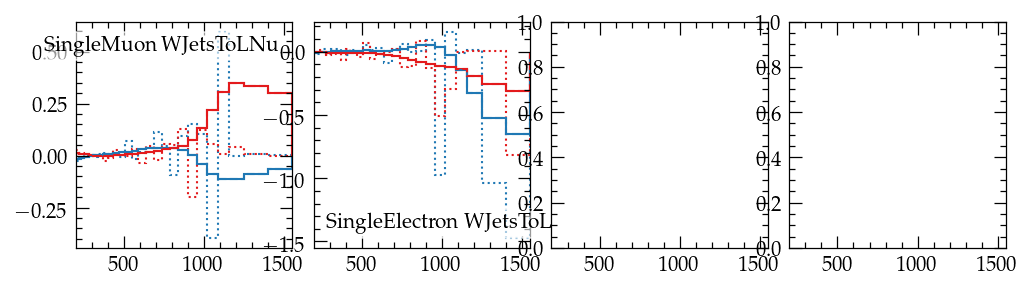

In [23]:
variation = "unclust"

region_processes = [
    #("Monojet", "ZJetsToNuNu"),
    #("Monojet", "WJetsToLNu"),
    #("Monojet", "MinorBkgs"),
    #("Monojet", "QCD"),
    #("SingleMuonPlus", "WJetsToLNu"),
    #("SingleMuonPlus", "MinorBkgs"),
    #("SingleMuonPlus", "QCD"),
    #("SingleMuonMinus", "WJetsToLNu"),
    #("SingleMuonMinus", "MinorBkgs"),
    #("SingleMuonMinus", "QCD"),
    ("SingleMuon", "WJetsToLNu"),
    ("SingleElectron", "WJetsToLNu"),
    #("SingleElectron", "MinorBkgs"),
    #("SingleTau", "WJetsToLNu"),
    #("SingleTau", "MinorBkgs"),
    #("SingleTau", "QCD"),
    #("DoubleMuon", "DYJetsToLL"),
    #("DoubleMuon", "MinorBkgs"),
    #("DoubleElectron", "DYJetsToLL"),
    #("DoubleElectron", "MinorBkgs"),
]

nvars = len(region_processes)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

for idx, (region, process) in enumerate(region_processes):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(variation))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(variation))]
    vari_up_pol = df_mc_fit_pol4.loc[(region, process, "{}Up".format(variation))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(variation))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(variation))]
    vari_do_pol = df_mc_fit_pol4.loc[(region, process, "{}Down".format(variation))]
    
    row = idx//4
    col = idx%4
    if len(region_processes)<=4:
        tax = ax[col]
    else:
        tax = ax[row,col]
    draw(
        tax,
        vari_up/nom-1, vari_up_smooth/nom-1, vari_up_pol/nom-1,
        vari_do/nom-1, vari_do_smooth/nom-1, vari_do_pol/nom-1,
        title=" ".join([region, process]),
    )

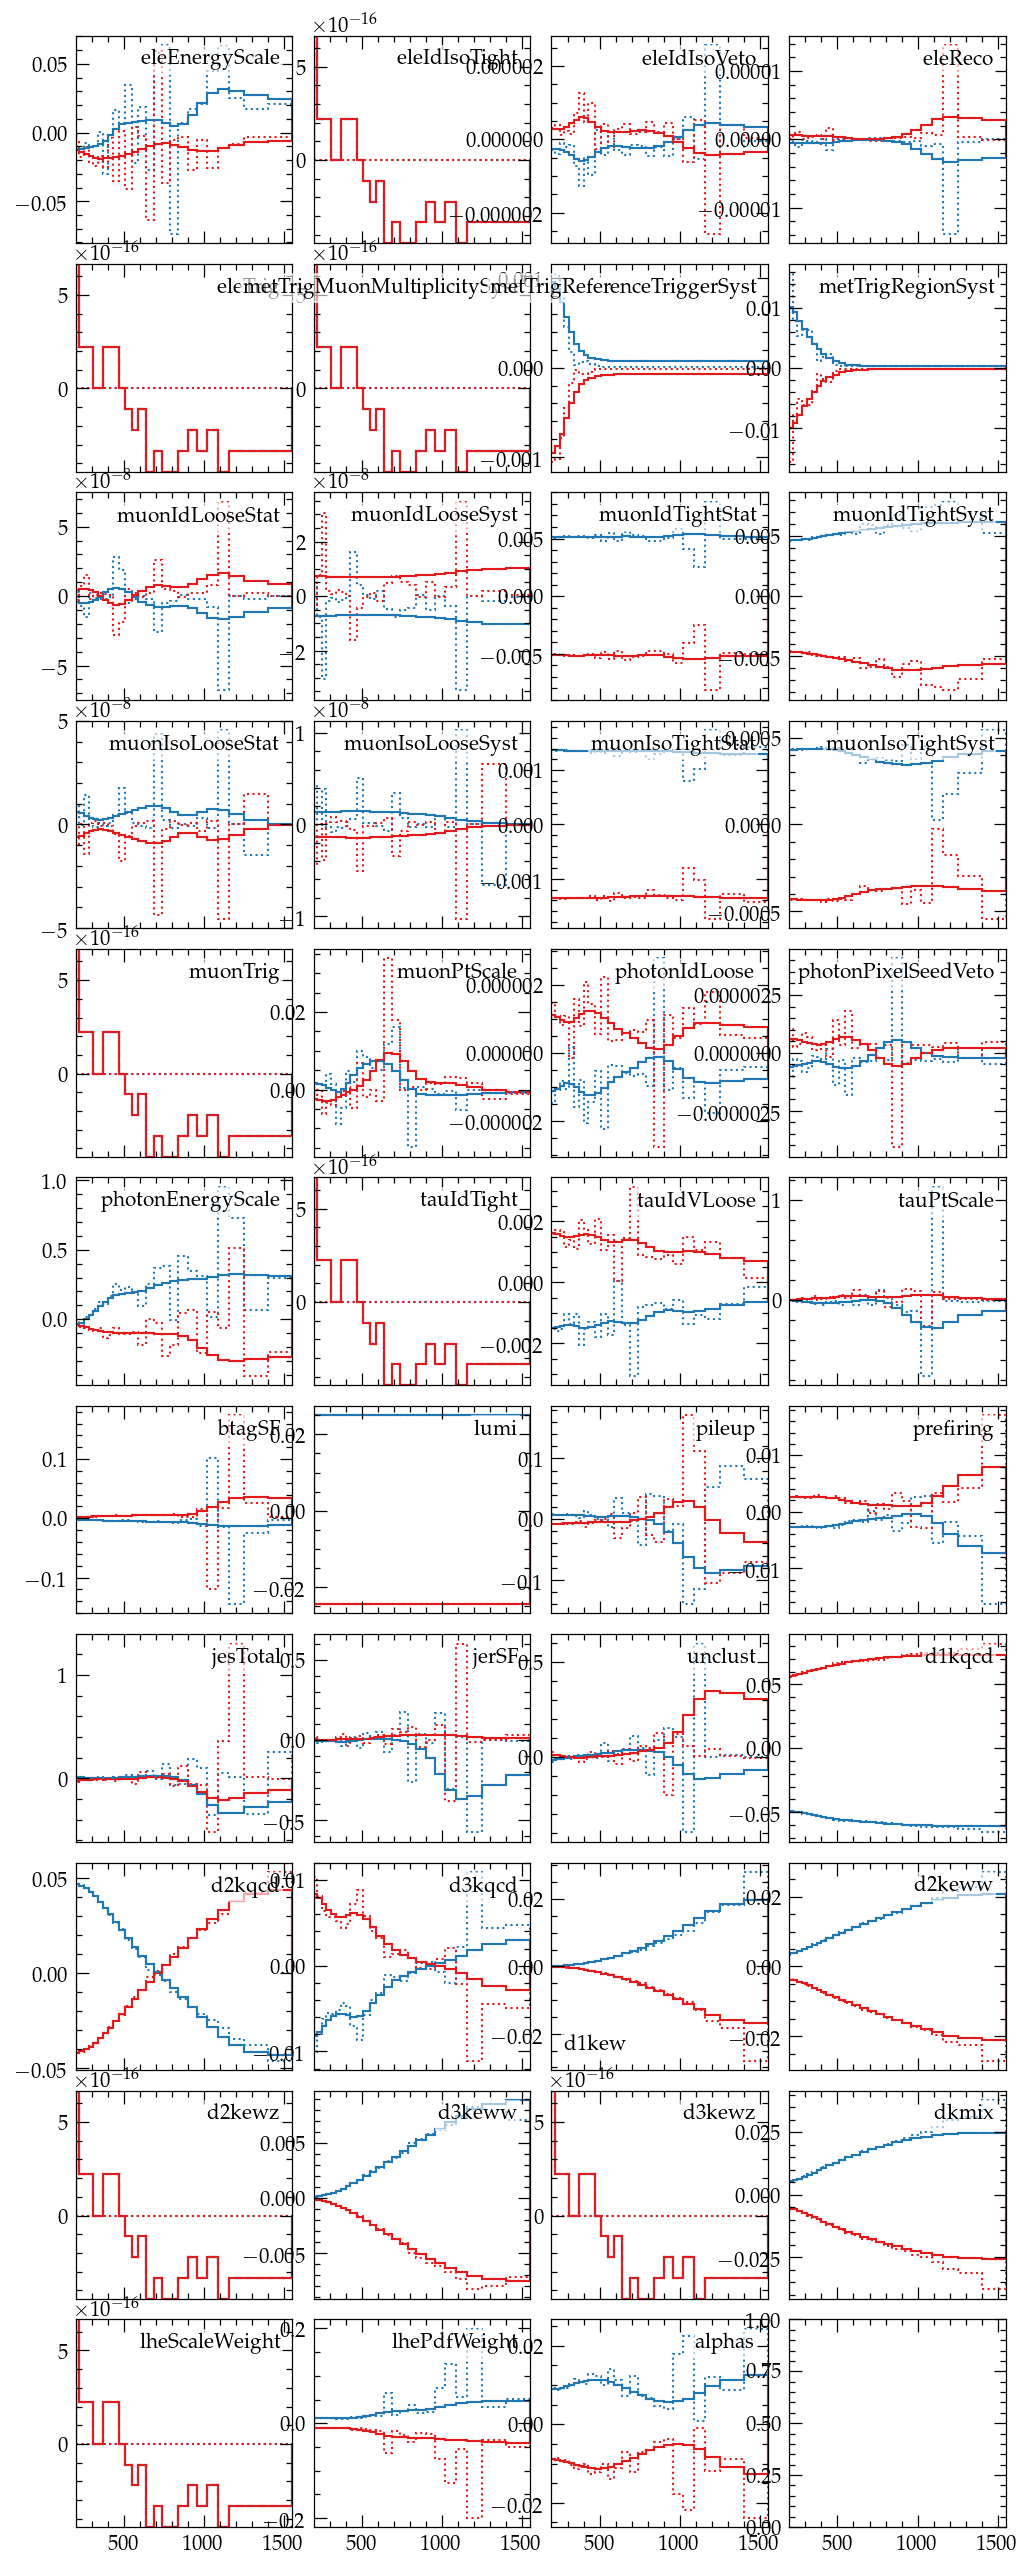

In [24]:
variations = [
    'eleEnergyScale', 'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig',
    'metTrigMuonMultiplicitySyst', 'metTrigReferenceTriggerSyst', 'metTrigRegionSyst',
    'muonIdLooseStat', 'muonIdLooseSyst', 'muonIdTightStat', 'muonIdTightSyst', 'muonIsoLooseStat', 'muonIsoLooseSyst', 'muonIsoTightStat', 'muonIsoTightSyst', 'muonTrig', 'muonPtScale',
    'photonIdLoose', 'photonPixelSeedVeto', 'photonEnergyScale',
    'tauIdTight', 'tauIdVLoose', 'tauPtScale',
    'btagSF',
    'lumi', 'pileup', 'prefiring',
    'jesTotal', 'jerSF', 'unclust',
    'd1kqcd', 'd2kqcd', 'd3kqcd', 'd1kew', 'd2keww', 'd2kewz', 'd3keww', 'd3kewz', 'dkmix', 'lheScaleWeight', 'lhePdfWeight', 'alphas',
]
nvars = len(variations)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

region, process = "SingleMuon", "WJetsToLNu"
for idx, vari in enumerate(variations):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(vari))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(vari))]
    vari_up_pol4 = df_mc_fit_pol4.loc[(region, process, "{}Up".format(vari))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(vari))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(vari))]
    vari_do_pol4 = df_mc_fit_pol4.loc[(region, process, "{}Down".format(vari))]
    
    row = idx//4
    col = idx%4
    draw(
        ax[row,col],
        vari_up/nom-1, vari_up_smooth/nom-1, vari_up_pol4/nom-1,
        vari_do/nom-1, vari_do_smooth/nom-1, vari_do_pol4/nom-1,
        title=vari,
    )

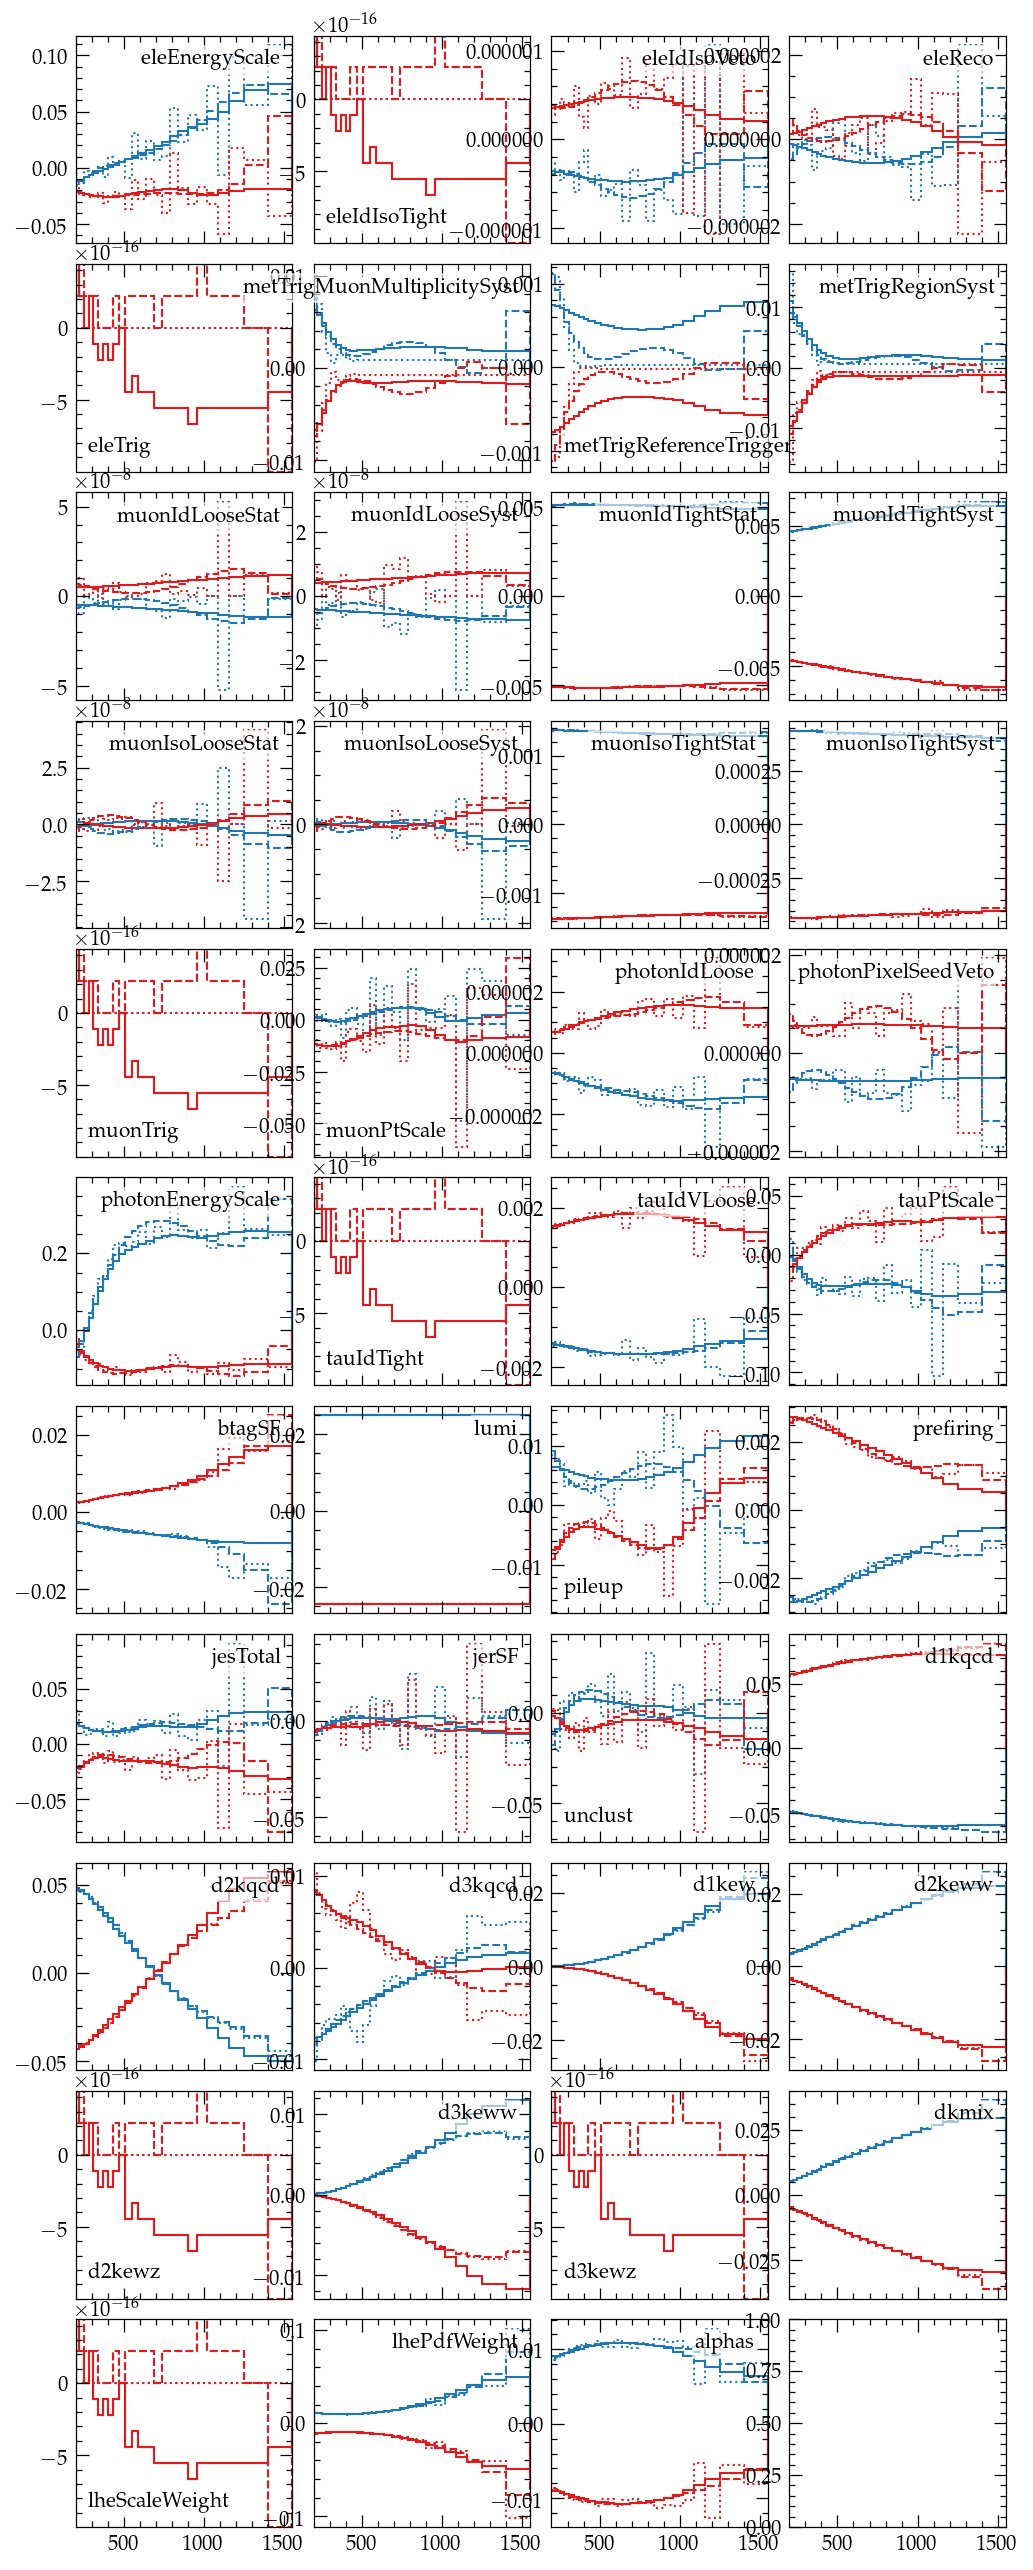

In [30]:
variations = [
    'eleEnergyScale', 'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig',
    'metTrigMuonMultiplicitySyst', 'metTrigReferenceTriggerSyst', 'metTrigRegionSyst',
    'muonIdLooseStat', 'muonIdLooseSyst', 'muonIdTightStat', 'muonIdTightSyst', 'muonIsoLooseStat', 'muonIsoLooseSyst', 'muonIsoTightStat', 'muonIsoTightSyst', 'muonTrig', 'muonPtScale',
    'photonIdLoose', 'photonPixelSeedVeto', 'photonEnergyScale',
    'tauIdTight', 'tauIdVLoose', 'tauPtScale',
    'btagSF',
    'lumi', 'pileup', 'prefiring',
    'jesTotal', 'jerSF', 'unclust',
    'd1kqcd', 'd2kqcd', 'd3kqcd', 'd1kew', 'd2keww', 'd2kewz', 'd3keww', 'd3kewz', 'dkmix', 'lheScaleWeight', 'lhePdfWeight', 'alphas',
]
nvars = len(variations)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

region, process = "SingleMuon", "WJetsToLNu"
for idx, vari in enumerate(variations):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(vari))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(vari))]
    vari_up_pol4 = df_mc_fit_pol4.loc[(region, process, "{}Up".format(vari))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(vari))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(vari))]
    vari_do_pol4 = df_mc_fit_pol4.loc[(region, process, "{}Down".format(vari))]
    
    row = idx//4
    col = idx%4
    draw(
        ax[row,col],
        vari_up/nom-1, vari_up_smooth/nom-1, vari_up_pol4/nom-1,
        vari_do/nom-1, vari_do_smooth/nom-1, vari_do_pol4/nom-1,
        title=vari,
    )

TypeError: draw() missing 2 required positional arguments: 'hist5' and 'hist6'

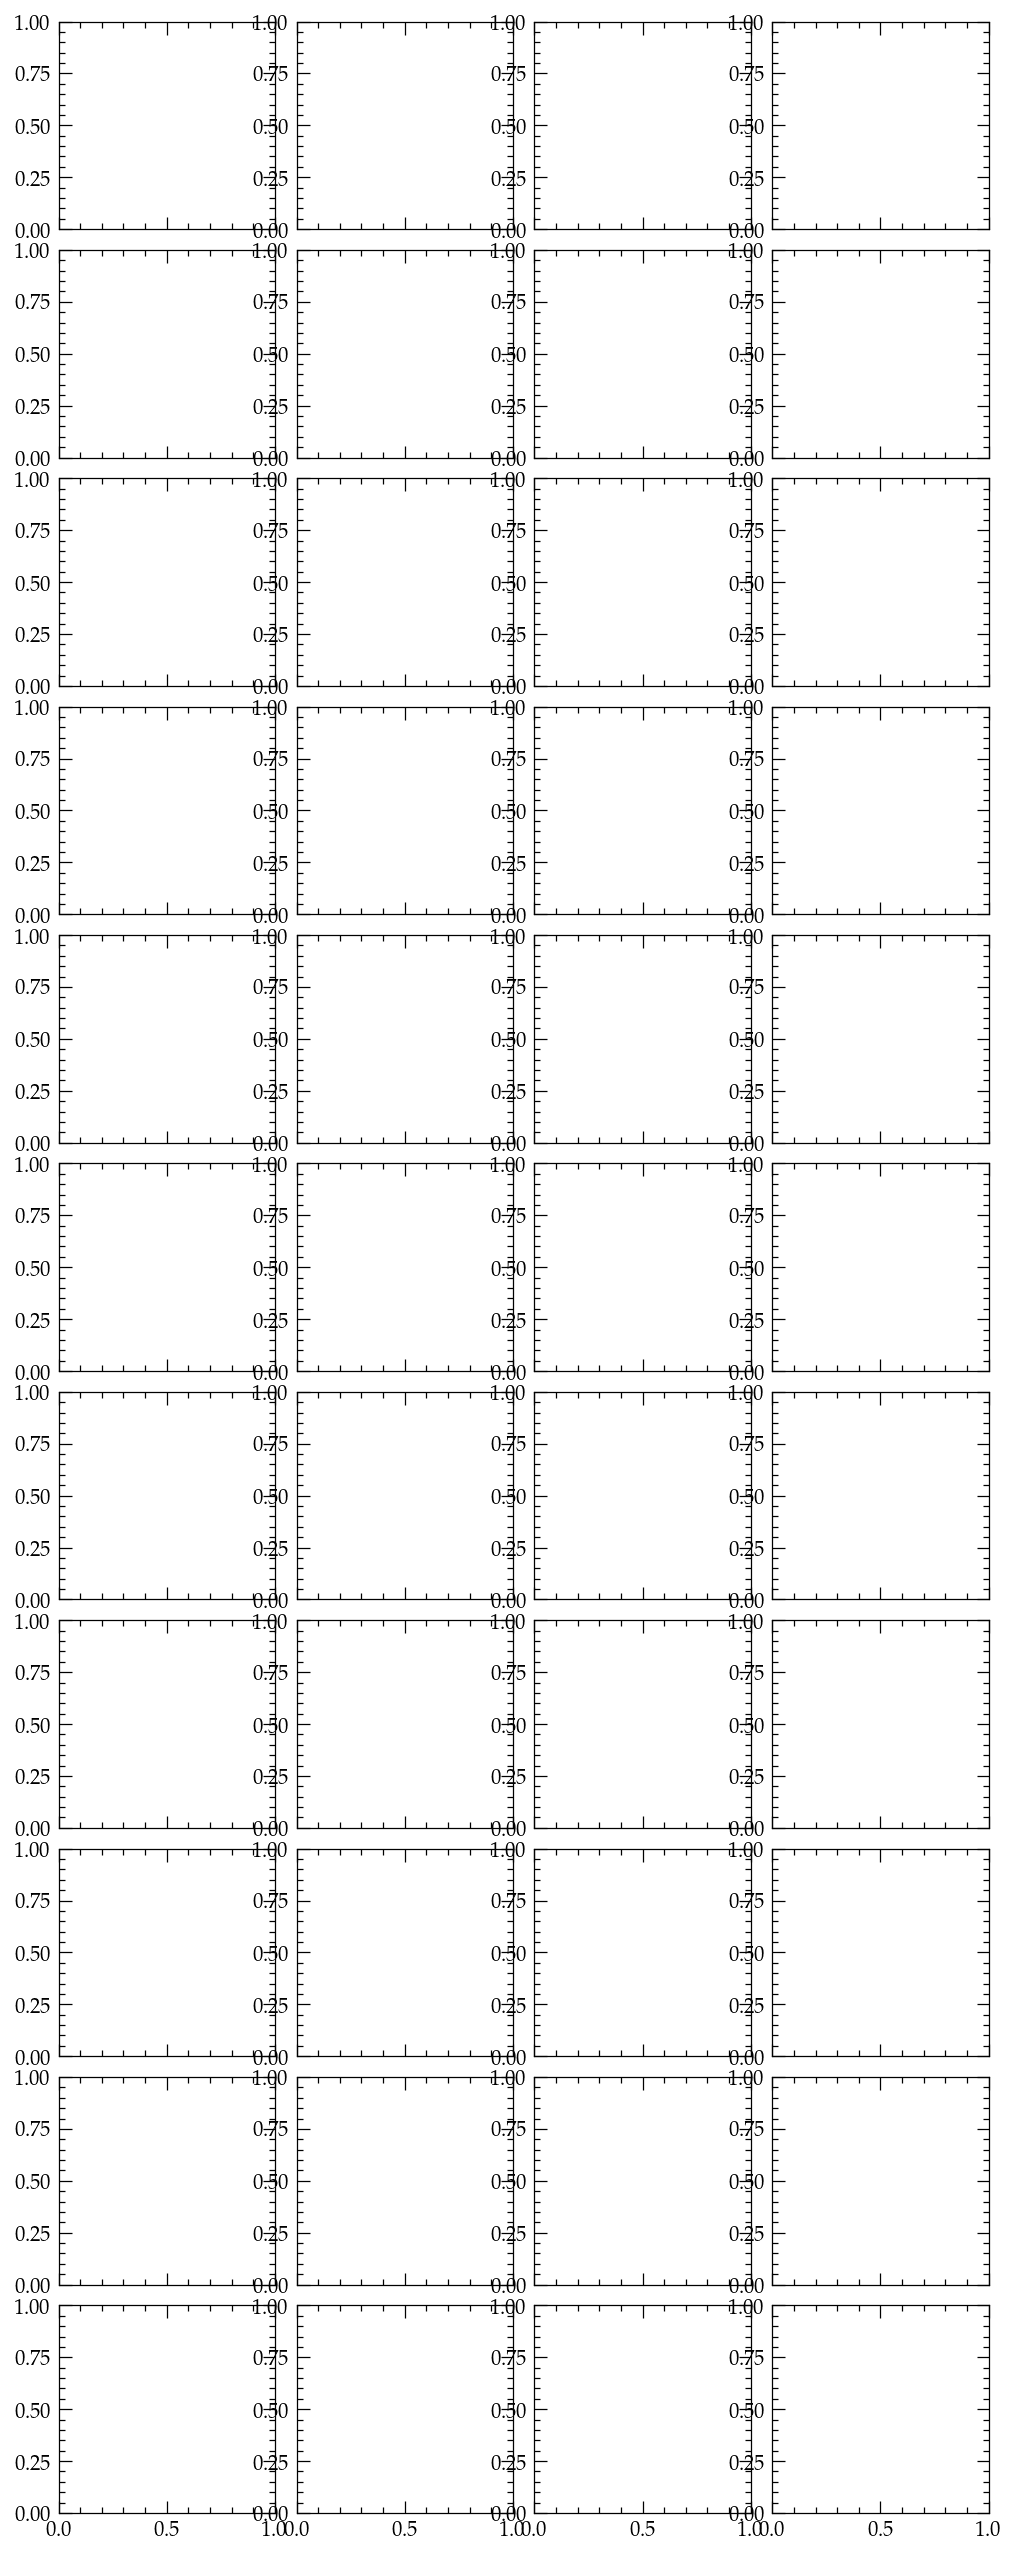

In [25]:
variations = [
    'eleEnergyScale', 'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig',
    'metTrigMuonMultiplicitySyst', 'metTrigReferenceTriggerSyst', 'metTrigRegionSyst',
    'muonIdLooseStat', 'muonIdLooseSyst', 'muonIdTightStat', 'muonIdTightSyst', 'muonIsoLooseStat', 'muonIsoLooseSyst', 'muonIsoTightStat', 'muonIsoTightSyst', 'muonTrig', 'muonPtScale',
    'photonIdLoose', 'photonPixelSeedVeto', 'photonEnergyScale',
    'tauIdTight', 'tauIdVLoose', 'tauPtScale',
    'btagSF',
    'lumi', 'pileup', 'prefiring',
    'jesTotal', 'jerSF', 'unclust',
    'd1kqcd', 'd2kqcd', 'd3kqcd', 'd1kew', 'd2keww', 'd2kewz', 'd3keww', 'd3kewz', 'dkmix', 'lheScaleWeight', 'lhePdfWeight', 'alphas',
]
nvars = len(variations)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

region, process = "Monojet", "WJetsToLNu"
for idx, vari in enumerate(variations):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(vari))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(vari))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(vari))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(vari))]
    
    row = idx//4
    col = idx%4
    draw(ax[row,col], vari_up/nom-1, vari_up_smooth/nom-1, vari_do/nom-1, vari_do_smooth/nom-1, title=vari)

In [ ]:
variations = [
    'eleEnergyScale', 'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig',
    'metTrigMuonMultiplicitySyst', 'metTrigReferenceTriggerSyst', 'metTrigRegionSyst',
    'muonIdLooseStat', 'muonIdLooseSyst', 'muonIdTightStat', 'muonIdTightSyst', 'muonIsoLooseStat', 'muonIsoLooseSyst', 'muonIsoTightStat', 'muonIsoTightSyst', 'muonTrig', 'muonPtScale',
    'photonIdLoose', 'photonPixelSeedVeto', 'photonEnergyScale',
    'tauIdTight', 'tauIdVLoose', 'tauPtScale',
    'btagSF',
    'lumi', 'pileup', 'prefiring',
    'jesTotal', 'jerSF', 'unclust',
    'd1kqcd', 'd2kqcd', 'd3kqcd', 'd1kew', 'd2keww', 'd2kewz', 'd3keww', 'd3kewz', 'dkmix', 'lheScaleWeight', 'lhePdfWeight', 'alphas',
]
nvars = len(variations)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

region, process = "Monojet", "MinorBkgs"
for idx, vari in enumerate(variations):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(vari))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(vari))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(vari))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(vari))]
    
    row = idx//4
    col = idx%4
    draw(ax[row,col], vari_up/nom-1, vari_up_smooth/nom-1, vari_do/nom-1, vari_do_smooth/nom-1, title=vari)

In [ ]:
variations = [
    'eleEnergyScale', 'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig',
    'metTrigMuonMultiplicitySyst', 'metTrigReferenceTriggerSyst', 'metTrigRegionSyst',
    'muonIdLooseStat', 'muonIdLooseSyst', 'muonIdTightStat', 'muonIdTightSyst', 'muonIsoLooseStat', 'muonIsoLooseSyst', 'muonIsoTightStat', 'muonIsoTightSyst', 'muonTrig', 'muonPtScale',
    'photonIdLoose', 'photonPixelSeedVeto', 'photonEnergyScale',
    'tauIdTight', 'tauIdVLoose', 'tauPtScale',
    'btagSF',
    'lumi', 'pileup', 'prefiring',
    'jesTotal', 'jerSF', 'unclust',
    'd1kqcd', 'd2kqcd', 'd3kqcd', 'd1kew', 'd2keww', 'd2kewz', 'd3keww', 'd3kewz', 'dkmix', 'lheScaleWeight', 'lhePdfWeight', 'alphas',
]
nvars = len(variations)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

region, process = "Monojet", "QCD"
for idx, vari in enumerate(variations):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(vari))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(vari))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(vari))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(vari))]
    
    row = idx//4
    col = idx%4
    draw(ax[row,col], vari_up/nom-1, vari_up_smooth/nom-1, vari_do/nom-1, vari_do_smooth/nom-1, title=vari)

In [ ]:
variations = [
    'eleEnergyScale', 'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig',
    'metTrigMuonMultiplicitySyst', 'metTrigReferenceTriggerSyst', 'metTrigRegionSyst',
    'muonIdLooseStat', 'muonIdLooseSyst', 'muonIdTightStat', 'muonIdTightSyst', 'muonIsoLooseStat', 'muonIsoLooseSyst', 'muonIsoTightStat', 'muonIsoTightSyst', 'muonTrig', 'muonPtScale',
    'photonIdLoose', 'photonPixelSeedVeto', 'photonEnergyScale',
    'tauIdTight', 'tauIdVLoose', 'tauPtScale',
    'btagSF',
    'lumi', 'pileup', 'prefiring',
    'jesTotal', 'jerSF', 'unclust',
    'd1kqcd', 'd2kqcd', 'd3kqcd', 'd1kew', 'd2keww', 'd2kewz', 'd3keww', 'd3kewz', 'dkmix', 'lheScaleWeight', 'lhePdfWeight', 'alphas',
]
nvars = len(variations)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

region, process = "SingleMuon", "WJetsToLNu"
for idx, vari in enumerate(variations):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(vari))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(vari))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(vari))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(vari))]
    
    row = idx//4
    col = idx%4
    draw(ax[row,col], vari_up/nom-1, vari_up_smooth/nom-1, vari_do/nom-1, vari_do_smooth/nom-1, title=vari)